In [1]:
import pandas as pd
import janitor
import gc
from utilities.utils import get_fulldata, process_land_area
from utilities.graph_utils import save_mpl_fig
from utilities.utils import pandas_to_tex
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.5, style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

FP_GENDER = '../data/hindi_eng_names_gender.csv.gz'
FP_ENG_NAMES = "../data/hindi_names_religion_translated.parquet"

/home/lsys/land/venv_land/lib/python3.10/site-packages/matplotlib/_fontconfig_pattern.py:88: DeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/home/lsys/land/venv_land/lib/python3.10/site-packages/matplotlib/_fontconfig_pattern.py:92: DeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  parser.resetCache()
/home/lsys/land/venv_land/lib/python3.10/site-packages/matplotlib/_fontconfig_pattern.py:88: DeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/home/lsys/land/venv_land/lib/python3.10/site-packages/matplotlib/_fontconfig_pattern.py:92: DeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  parser.resetCache()
/home/lsys/land/venv_land/lib/python3.10/site-packages/matplotlib/_fontconfig_pattern.py:88: DeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/home/lsys/land/venv_land/lib/python3.10/site-packa

In [2]:
usecols = ['account_no', 'name_of_ryot', '6', '7', '8']
df = (
    get_fulldata(usecols=usecols, low_memory=False)
    .pipe(process_land_area)
    .merge(
        (
            pd.read_parquet(FP_ENG_NAMES, columns=["name", "eng_name"])
            .query("eng_name!=''")
            .drop_duplicates("name")
            .rename_column("name", "name_of_ryot")
        ),
         how="left", on="name_of_ryot", validate="m:1"
    )
    .assign(firstname=lambda df: df.eng_name.str.split().str[0])
    # Merge gender (by eng first name)
    .merge(
        (
            pd.read_csv(FP_GENDER, usecols=["firstname", "pred_gender"])
            .rename_column("pred_gender", "gender")
        ), how="left", on="firstname", validate="m:1"
    )
    .dropna(subset="gender")
)
df.info()
print(f"{df['account_no'].nunique()=}")
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 38589535 entries, 0 to 38589907
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   name_of_ryot  object 
 1   account_no    int64  
 2   acres         float64
 3   decimals      float64
 4   hectare       float64
 5   tt_area_acre  float64
 6   eng_name      object 
 7   firstname     object 
 8   gender        object 
dtypes: float64(4), int64(1), object(4)
memory usage: 2.9+ GB
df['account_no'].nunique()=11904801


,name_of_ryot,account_no,acres,decimals,hectare,tt_area_acre,eng_name,firstname,gender
0,कपिलदेव पाठक,1801010001000002,0.0,66.0,0.0,0.66,kapildev pathak,kapildev,male
1,कपिलदेव पाठक,1801010001000002,0.0,8.0,0.0,0.08,kapildev pathak,kapildev,male
2,कपिलदेव पाठक,1801010001000002,0.0,6.0,0.0,0.06,kapildev pathak,kapildev,male


In [3]:
df["name_of_ryot"].nunique()

3197245

In [4]:
df["account_no"].nunique()

11904801

## Summary numbers

In [5]:
# Land plots are owned by woman
n_land_woman = len(df.query("gender=='female'"))
perc_land_woman = 100*n_land_woman/len(df)

print(f"{n_land_woman:,.0f} ({perc_land_woman:.1f}%) land plots are owned by woman")

7,577,144 (19.6%) land plots are owned by woman


In [6]:
df_num_plots = (df
                .groupby(["account_no", 'gender'])
                .size()
                .reset_index()
                .rename_column(0, 'nplots')
               )
df_num_plots.head(3)

,account_no,gender,nplots
0,101010273000001,female,2
1,101010273000002,male,8
2,101010273000003,male,1


In [7]:
n_accounts_woman = len(df_num_plots.query("gender=='female'"))
perc_accounts_woman = 100*n_accounts_woman/len(df_num_plots)

print(f"{n_accounts_woman:,.0f} ({perc_accounts_woman:.1f}%) accounts are under woman")

2,579,084 (21.7%) accounts are under woman


## Tabulate overall shares by gender

In [8]:
_x = "tt_area_acre"
df_landshares = (
    df.groupby(["gender"])[_x].sum().reset_index()
    .assign(landshare=lambda df_: 100 * (df_[_x]/df_[_x].sum()))
    .rename_column(_x, "land")
)
rounding_error = 0.01
assert rounding_error > (100 - df_landshares["landshare"].sum())
df_landshares

,gender,land,landshare
0,female,4.166503e+06,13.130151
1,male,2.756583e+07,86.869849


In [9]:
_x = "nplots"
df_plotshares = (
    df_num_plots.groupby(["gender"])[_x].sum().reset_index()
    .assign(plotshare=lambda df_: 100 * (df_[_x]/df_[_x].sum()))
    .rename_column(_x, "plots")
)
assert df_plotshares["plotshare"].sum()==100
df_plotshares

,gender,plots,plotshare
0,female,7577144,19.63523
1,male,31012391,80.36477


In [10]:
df_shares = (
    df_plotshares.merge(df_landshares, on=["gender"], how="left", validate="1:1")
    .sort_values("landshare", ascending=False, ignore_index=True)
    .assign(landshare_cs=lambda df_: df_["landshare"].cumsum())
    .assign(plotshare_cs=lambda df_: df_["plotshare"].cumsum())
    .reorder_columns(["gender", "plots", "plotshare", "plotshare_cs"])
    # see 01_secc_gender_caste_proportions.ipynb
    .assign(base_adultpop=[52.316132609637044,47.683867390362984])
    .assign(gender=["Men", "Women"])
)
pandas_to_tex(df_shares, "../tables/landshares_by_gender", float_format="%.2f")
df_shares

,gender,plots,plotshare,plotshare_cs,land,landshare,landshare_cs,base_adultpop
0,Men,31012391,80.36477,80.36477,2.756583e+07,86.869849,86.869849,52.316133
1,Women,7577144,19.63523,100.00000,4.166503e+06,13.130151,100.000000,47.683867


### Number of plots per account, by gender

In [11]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_nplot_perc_men = (df_num_plots
                      .query("gender=='male'")
                      .nplots.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('nplots', 'nplots_men')
                      .astype({"nplots_men":int})
                     )
tab_nplot_perc_women = (df_num_plots
                      .query("gender=='female'")
                      .nplots.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('nplots', 'nplots_women')
                      .astype({"nplots_women":int})
                     )
tab_nplot_perc = (tab_nplot_perc_women
                  .merge(tab_nplot_perc_men, 
                         on="Percentile", 
                         how="left", 
                         validate="1:1"
                        )
                  .assign(
                      nplots_women=lambda df: df.nplots_women.map('{:,.0f}'.format),
                      nplots_men=lambda df: df.nplots_men.map('{:,.0f}'.format)
                  )
                 )
pandas_to_tex(tab_nplot_perc, "../tables/percentiles_landplots_per_accountholder_gender", float_format="%.2f")
tab_nplot_perc

,Percentile,nplots_women,nplots_men
0,0.00,1,1
1,0.10,1,1
2,0.20,1,1
3,0.30,1,1
4,0.40,1,1
5,0.50,1,1
6,0.60,1,1
7,0.70,2,2
8,0.80,3,3
9,0.90,6,7


In [12]:
# Prep graph options (fold cell)
# palette = ['indigo', 'gold'] # gender (and ethnic?) neutral
# palette = "cividis" # gender (and ethnic?) neutral
# cmap = cm.get_cmap('viridis', 2)
# palette = []
# for i in range(cmap.N):
#     rgba = cmap(i)
#     palette.append(mpl.colors.rgb2hex(rgba))
LINESTYLES = ["-", "--"]
DISPLOT_OPTS = dict(
    aspect=1.5,
    height=6,
    hue="gender",
    legend=False,
    palette="cividis",
    linewidth=2.5,
)
HISTDENSITY_OPTS = dict(
    hue="gender",
    legend=False,
    palette="cividis",
)

LEGEND_OPTS = {"title":"", 
               "loc":'best', 
               "labels":["Male", "Female"], 
               "frameon":False, 
               "fontsize":24, 
               "handletextpad":0.3
              }
# cutoff = 0.95  # percentile to trim at 

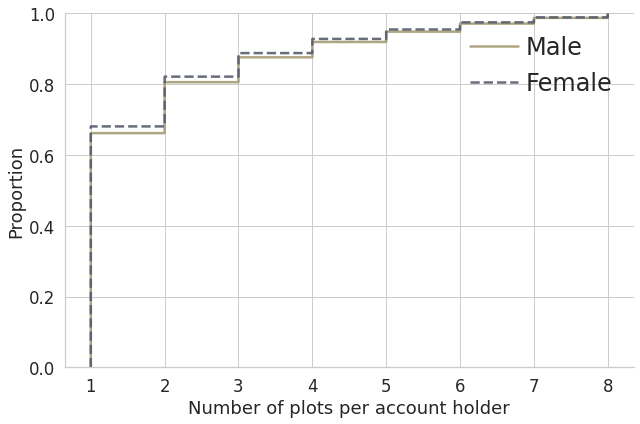

In [13]:
# Empirical CDF of #plots owned per account (fold cell)
_n = 8

g = sns.displot(
    x="nplots", 
    data=df_num_plots.query(f"nplots<={_n}"), 
    alpha=0.9,
    kind="ecdf",
    **DISPLOT_OPTS,
)
for line, linestyle in zip(g.axes[0][0].lines, LINESTYLES):
    line.set_linestyle(linestyle)
plt.legend(**LEGEND_OPTS)
plt.xlabel("Number of plots per account holder")
save_mpl_fig('../figures/number_plots_per_accountholder_ecdf_gender')

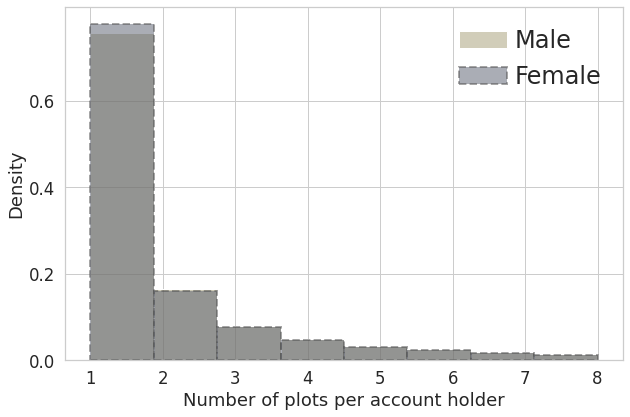

In [14]:
# Histogram of #plots owned per account (fold cell)
_, ax = plt.subplots(figsize=(10,6.5))
sns.histplot(data=df_num_plots.query(f"nplots<={_n}"),
             x='nplots', 
             bins=_n, 
             stat='density', 
             common_norm=False,
             **HISTDENSITY_OPTS,
             alpha=.5,
             ax=ax,
            )
plt.xlabel("Number of plots per account holder")
plt.yticks([0, 0.2,.4,.6])

bars = ax.containers[1].get_children()  # second set is for female
for bar in bars:
    bar.set_linestyle('--')
    bar.set_linewidth(2)
    bar.set_edgecolor("0.3")
    bar.set_alpha(.5)
plt.legend(**LEGEND_OPTS)    
save_mpl_fig('../figures/number_plots_per_accountholder_histogram_gender')    

### Land area per account, by gender

In [15]:
df_landarea = (df
               .groupby(["account_no", 'gender'])["tt_area_acre"]
               .sum()
               .reset_index()
              )
df_landarea.head(3)

,account_no,gender,tt_area_acre
0,101010273000001,female,0.585
1,101010273000002,male,1.545
2,101010273000003,male,0.080


In [16]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_area_perc_men = (df_landarea
                      .query("gender=='male'")
                      .tt_area_acre.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('tt_area_acre', 'area_men')
                     )
tab_area_perc_women = (df_landarea
                      .query("gender=='female'")
                      .tt_area_acre.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('tt_area_acre', 'area_women')
                     )
tab_area_perc = (tab_area_perc_women
                 .merge(tab_area_perc_men, 
                        on="Percentile", 
                        how="left", 
                        validate="1:1"
                       )
                  .assign(
                      area_women=lambda df: df.area_women.map('{:,.2f}'.format),
                      area_men=lambda df: df.area_men.map('{:,.2f}'.format)
                  )                 
                )
pandas_to_tex(tab_area_perc, "../tables/percentiles_landarea_per_accountholder_gender", float_format="%.2f")
tab_area_perc

,Percentile,area_women,area_men
0,0.00,0.00,0.00
1,0.10,0.03,0.04
2,0.20,0.06,0.08
3,0.30,0.11,0.13
4,0.40,0.18,0.22
5,0.50,0.28,0.33
6,0.60,0.43,0.50
7,0.70,0.66,0.77
8,0.80,1.06,1.25
9,0.90,2.13,2.50


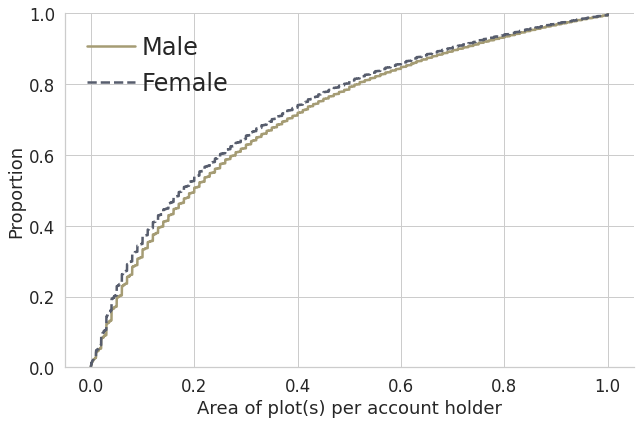

In [17]:
# Empirical CDF of land plot area owned per account (fold cell)
_area = 1

g = sns.displot(
    x="tt_area_acre", 
    data=df_landarea.query(f"tt_area_acre<={_area}"), 
    kind="ecdf",
    **DISPLOT_OPTS,
)
for line, linestyle in zip(g.axes[0][0].lines, LINESTYLES):
    line.set_linestyle(linestyle)
plt.legend(**LEGEND_OPTS)
plt.xlabel("Area of plot(s) per account holder")
save_mpl_fig('../figures/plot_area_per_accountholder_ecdf_gender')    

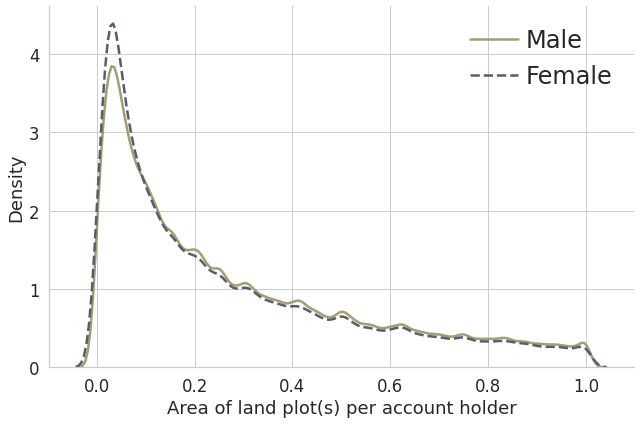

In [18]:
# Histogram of land plot area owned per account (fold cell)
g = sns.displot(data=df_landarea.query(f"tt_area_acre<={_area}"), 
                 x="tt_area_acre", 
                 kind='kde',
                 common_norm=False,
                 **DISPLOT_OPTS,
                )
g.set_xlabels("Area of land plot(s) per account holder")
plt.locator_params(axis="y", nbins=5)
for line, linestyle in zip(g.axes[0][0].lines, LINESTYLES):
    line.set_linestyle(linestyle)
plt.legend(**LEGEND_OPTS)